# Airline Tweets - Three Generations (👵 👩 👧) of Sentiment Analysis (😊 😟)
- Author: Oliver Mueller
- Last update: 26.01.2024

## Initialize notebook
Load required packages. Set up workspace, e.g., set theme for plotting and initialize the random number generator.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import spacy
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from transformers import pipeline
import torch

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

/var/folders/4d/0rd3mwcn4y7gv39shh0dy_0w0000gn/T/ipykernel_17164/2172105861.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/Users/oliver/miniconda3/envs/prodok/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Problem description

We have a collection of 10.000 tweets directed at airlines in the US. Originally, this dataset came from Crowdflower's Data for Everyone library (discontinued). The data was collected in February 2015 and multiple human annotators were asked classify the tweets into the classes `positive` and `negative`.

## Load data

In [2]:
tweets = pd.read_csv("data/airlinetweets.csv")
tweets.head()

,tweet_id,airline,text,sentiment_groundtruth,tweet_created
0,5.698464e+17,American,@AmericanAir thank you for doing the best you ...,positive,2015-02-23
1,5.697151e+17,American,@AmericanAir wow that's helpful.,positive,2015-02-22
2,5.678138e+17,United,@united so I wasted 40mins filling in 2 online...,negative,2015-02-17
3,5.702325e+17,American,@AmericanAir my seat is disgusting. Old and di...,negative,2015-02-24
4,5.696695e+17,US Airways,@USAirways ur specialist said they would talk ...,negative,2015-02-22


## Prepare data

Perform the typical splits into features and labels and training and test sets.

In [3]:
X = tweets[["tweet_id", "airline", "text"]]
y = tweets[["sentiment_groundtruth"]]

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(8000, 3)
(8000, 1)
(2000, 3)
(2000, 1)


## Exploratory data analysis

Let's explore the training data a little bit. It's always a good idea to first read a couple of texts.

In [5]:
print(X_train.iloc[0]["text"])
print("===")
print(y_train.iloc[0]["sentiment_groundtruth"])

@AmericanAir stiiiil waiting. Please respond as my flight leaves in 2 1/2 hrs
===
negative


In [6]:
print(X_train.iloc[1]["text"])
print("===")
print(y_train.iloc[1]["sentiment_groundtruth"])

@AmericanAir yes we did make it home. But by no means am I happy. I've always chosen AA as my 1st choice when flying, I'm rethinking that...
===
negative


Visualize the distribution of tweets across the positive and negative classes.

<Axes: xlabel='sentiment_groundtruth', ylabel='count'>

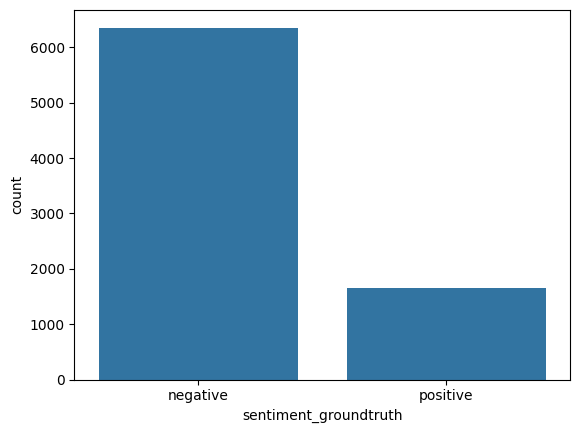

In [7]:
sns.countplot(data=y_train, x="sentiment_groundtruth")

In [8]:
y_train["sentiment_groundtruth"].value_counts()

sentiment_groundtruth
negative    6355
positive    1645
Name: count, dtype: int64

In [9]:
y_train["sentiment_groundtruth"].value_counts()[1]/y_train.shape[0]

/var/folders/4d/0rd3mwcn4y7gv39shh0dy_0w0000gn/T/ipykernel_17164/1328965554.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_train["sentiment_groundtruth"].value_counts()[1]/y_train.shape[0]


0.205625

## 1st Generation 👵 - Dictionary-based Sentiment Analysis with VADER

<center><br><img width=600 src="https://raw.githubusercontent.com/olivermueller/aml4ta-2021/main/resources/gen1.png"/><br></center>

Let's start by trying a dictinary-based approach to sentiment analysis. In the following, we will use `VADER` (Valence Aware Dictionary and sEntiment Reasoner), a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media (https://github.com/cjhutto/vaderSentiment).

Initialize the VADER sentiment analyzer and try it out on a single example from the training set.

In [10]:
vader_sa_classifier = SentimentIntensityAnalyzer()

In [11]:
print(X_train.iloc[1]["text"])
vader_sa_classifier.polarity_scores(X_train.iloc[1]["text"])

@AmericanAir yes we did make it home. But by no means am I happy. I've always chosen AA as my 1st choice when flying, I'm rethinking that...


{'neg': 0.083, 'neu': 0.712, 'pos': 0.205, 'compound': 0.6249}

Use VADER to analyze all tweets from the test set.

In [12]:
y_test_vader = []
for index, row in X_test.iterrows():
    vs = vader_sa_classifier.polarity_scores(row["text"])
    if vs["compound"] > 0:
      sentiment = "positive"
    else:
      sentiment = "negative"
    y_test_vader.append(sentiment)

Let's look at some exemplary predictions and calculate the accuracy using all observations from the test set.

In [13]:
y_test_vader[0:10]

['positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'negative',
 'negative',
 'positive',
 'negative']

In [14]:
accuracy_score(y_test, y_test_vader)

0.6485

Looking at the confusion matrix gives us an idea what kind of errors the model makes.

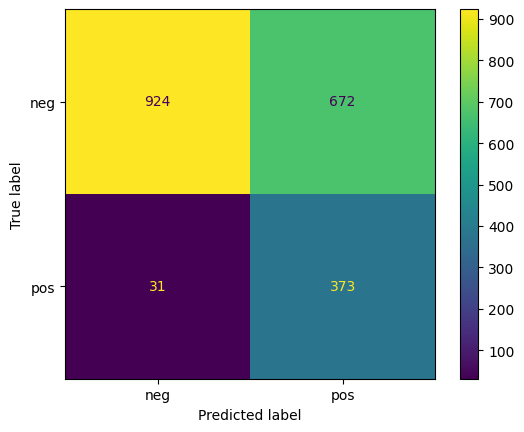

In [15]:
cm = confusion_matrix(y_test, y_test_vader)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["neg", "pos"])
disp.plot()
plt.show()

## 2nd Generation 👩 - Statistical Sentiment Analysis with Bag-of-Words Representation and Regularized Logistic Regression

<center><br><img width=600 src="https://raw.githubusercontent.com/olivermueller/aml4ta-2021/main/resources/gen2.png"/><br></center>

Next, we will use a statistical approach. More precisely, we create a bag-of-words representation of our tweets and then train a regularized logistic regression model to learn linear relationships between single words and sentiment.

Before we create a term-document matrix, we perform some standard preprocessing like lemmatization. We will use the excellent `Spacy` (https://spacy.io/) library for this.

In [16]:
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser'])
def spacy_prep(dataset):
  dataset = dataset.to_dict("records")
  for i, entry in enumerate(dataset):
      text = nlp(entry[u'text'])
      tokens_to_keep = []
      for token in text:
          if token.is_alpha:
              tokens_to_keep.append(token.lemma_.lower())
      entry[u'text_prep'] = " ".join(tokens_to_keep)
  dataset = pd.DataFrame(dataset)
  return(dataset)

In [17]:
X_train = spacy_prep(X_train)

In [18]:
X_train.head()

,tweet_id,airline,text,text_prep
0,5.698509e+17,American,@AmericanAir stiiiil waiting. Please respond a...,stiiiil wait please respond as my flight leave...
1,5.697709e+17,American,@AmericanAir yes we did make it home. But by n...,yes we do make it home but by no means be i ha...
2,5.696369e+17,United,@united Would be nice if @staralliance partner...,would be nice if partner ticket that do provid...
3,5.693638e+17,United,@united just DM'd,just
4,5.699694e+17,US Airways,@USAirways owes Tammy from the Winston-Salem c...,owe tammy from the winston salem call center f...


Now we are ready to create the term-document matrix for the training set. The `CountVectorizer` from the sklearn package performs this job for us.

In [19]:
count_vect = CountVectorizer(min_df=2)
X_train_matrix = count_vect.fit_transform(X_train["text_prep"].tolist())

In [20]:
X_train_matrix.shape

(8000, 3283)

In [21]:
X_train_matrix[0:10,0:10].todense()

matrix([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

Finally, we fit a logistic regression model on the training set.

In [22]:
bow_sa_classifier = LogisticRegression(max_iter=1000, penalty="l1", solver="liblinear")
bow_sa_classifier.fit(X_train_matrix, np.ravel(y_train))

LogisticRegression(max_iter=1000, penalty='l1', solver='liblinear')

Now that we have a sentiment classifier especially trained to predict sentiments for our data, we can apply it to the test set and evaluate its predictive accuracy. Note that we have to repeat the exact same preprocessing steps that we applied to the training set also to the test set.

In [23]:
X_test = spacy_prep(X_test)
X_test_matrix = count_vect.transform(X_test["text_prep"])

In [24]:
y_test_bow = bow_sa_classifier.predict(X_test_matrix)

In [25]:
accuracy_score(y_test, y_test_bow)

0.916

Let's look at the confusion matrix.

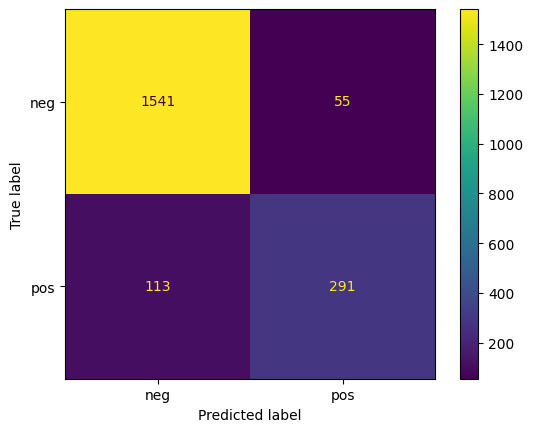

In [26]:
cm = confusion_matrix(y_test, y_test_bow)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["neg", "pos"])
disp.plot()
plt.show()

The performance is impressive. In addition, we can inspect the coefficients our logistic regression model in order to understand how the model makes predictions.

In [27]:
coeffs = bow_sa_classifier.coef_[0].tolist()
words = count_vect.get_feature_names_out()
words_with_coeffs = pd.DataFrame(coeffs, words, columns=["coeff"])

In [28]:
words_with_coeffs.sort_values("coeff", ascending=False).head(20)

,coeff
awesome,3.842704
thankful,3.646532
wonderful,3.640186
thank,3.197382
denverairport,3.104900
kudo,3.004962
impressed,2.984862
love,2.765734
excellent,2.703375
cool,2.703042


In [29]:
words_with_coeffs.sort_values("coeff", ascending=True).head(20)

,coeff
ruin,-3.625629
feedback,-3.575022
rude,-3.053434
nothing,-2.972342
screw,-2.879877
strand,-2.612194
suck,-2.582353
money,-2.523582
bad,-2.284847
luggage,-2.243196


## 3rd Generation 👧 - Neural Sentiment Analysis with Pre-trained BERT

<center><br><img width=600 src="https://raw.githubusercontent.com/olivermueller/aml4ta-2021/main/resources/transfer_learning.png"/><br></center>

Lastly, we will try a pre-trained BERT sentiment analysis model on our data. The model has been pre-trained on Wikipedia and BookCorpus using a language modeling task and then fine-tuned for sentiment analysis on more than 200.000 labeled sentences from movie reviews.

The [Huggingface](https://huggingface.co/) model hub is a great place to find pre-trained models.

In [30]:
transformer_sa_classifier = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
model.safetensors: 100%|██████████| 268M/268M [00:54<00:00, 4.94MB/s] 
tokenizer_config.json: 100%|██████████| 48.0/48.0 [00:00<00:00, 432kB/s]
vocab.txt: 100%|██████████| 232k/232k [00:00<00:00, 953kB/s]


As the model is already trained, we can directly apply it to our test data and assess it's predictive accuracy.

In [31]:
results = transformer_sa_classifier(X_test["text"].to_list())

y_test_transformer = []
for result in results:
  y_test_transformer.append(result["label"].lower())

In [32]:
accuracy_score(y_test, y_test_transformer)

0.8965

And the confusion matrix...

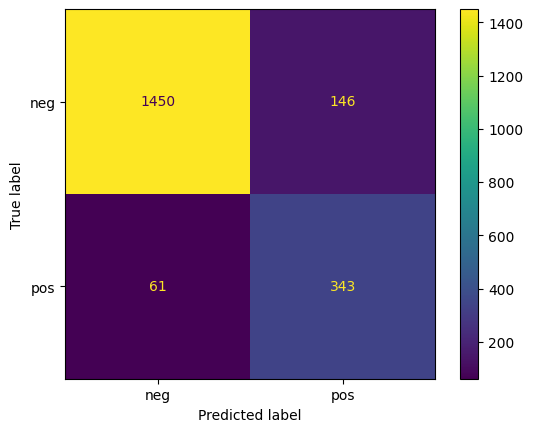

In [33]:
cm = confusion_matrix(y_test, y_test_transformer)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["neg", "pos"])
disp.plot()
plt.show()

Not bad, given that this model has been trained on 🎥 reviews and we applied it to 🛫 tweets.